# [Hw08] Convolutional Neural Network
Jeong Ji Hoon 2016010980

## Load Packages

In [1]:
import os
import struct
import numpy as np
import tensorflow as tf
import sys
import gzip
import matplotlib.pyplot as plt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Load the MNIST train and test data sets

In [2]:
# 수업 자료의 코드를 그대로 사용.

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte' % kind)

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels


# unzips mnist
if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

# 2. Set training & validation & test data

## Dividing the Dataset

In [3]:
# 55000 개와 5000개로 traning set을 나눔.

X, y = load_mnist('', kind='train')

X_train = X[:55000,:]
y_train = y[:55000]
X_valid = X[55000:60000,:]
y_valid = y[55000:60000]

X_test, y_test = load_mnist('', kind='t10k')
X_test = X_test[:10000,:]
y_test = y_test[:10000]


## Standardization

In [4]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_valid_centered = X_valid - mean_vals
X_test_centered = (X_test - mean_vals) / std_val

del X_train, X_valid, X_test

# 3. Create and Evaluate CNN with low-level tensorflow API

## 3-1. Define functions for layers

### convolution layer (not changed)

In [5]:
def conv_layer(input_tensor, name,
               kernel_size, n_output_channels,
               padding_mode='SAME', strides=(1, 1, 1, 1)):
    with tf.variable_scope(name):
        ## get n_input_channels:
        ##   input tensor shape:
        ##   [batch x width x height x channels_in]
        input_shape = input_tensor.get_shape().as_list()
        n_input_channels = input_shape[-1]

        weights_shape = (list(kernel_size) +
                         [n_input_channels, n_output_channels])

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_channels]))
        print(biases)
        conv = tf.nn.conv2d(input=input_tensor,
                            filter=weights,
                            strides=strides,
                            padding=padding_mode)
        print(conv)
        conv = tf.nn.bias_add(conv, biases,
                              name='net_pre-activation')
        print(conv)
        conv = tf.nn.relu(conv, name='activation')
        print(conv)

        return conv

### fully connected layer (not changed)

In [6]:
def fc_layer(input_tensor, name,
             n_output_units, activation_fn=None):
    with tf.variable_scope(name):
        input_shape = input_tensor.get_shape().as_list()[1:]
        n_input_units = np.prod(input_shape)
        if len(input_shape) > 1:
            input_tensor = tf.reshape(input_tensor,
                                      shape=(-1, n_input_units))

        weights_shape = [n_input_units, n_output_units]

        weights = tf.get_variable(name='_weights',
                                  shape=weights_shape)
        print(weights)
        biases = tf.get_variable(name='_biases',
                                 initializer=tf.zeros(
                                     shape=[n_output_units]))
        print(biases)
        layer = tf.matmul(input_tensor, weights)
        print(layer)
        layer = tf.nn.bias_add(layer, biases,
                               name='net_pre-activation')
        print(layer)
        if activation_fn is None:
            return layer

        layer = activation_fn(layer, name='activation')
        print(layer)
        return layer

## 3-2. Define the function for Creating CNN
- <font color='red' >**기존 코드에는 L1 xor L2 regularization term이 없음**</font>
- 이에 LnReg parameter로 regularization을 할지, 한다면 L1으로 할지 L2로 할지를 받음.
- LnReg 값이 1 혹은 2로 설정이 되어 각각 L1 혹은 L2 regularization이 penalty term으로 들어간다면, LnBeta 파라미터에 람다 값을 넣어줌.
- L1의 경우 abs를 한뒤 reduced sum을 시켜서 절대값 취한뒤 합해주는 방식을 취함.
- L2의 경우는 자체 함수인 tf.nn.l2_loss 함수를 사용함.
- 과제 지시에 따라 모든 weight에 대해 penalize 하지 않고 첫번째 fully connected layer인 'fc_3'에 대해서만 penalize를 진행.
- 추가로 LnReg 값으로 0, 1, 2가 아닌 다른 값을 집어 넣으면 raise error.
- softmax_cross_entropy_with_logits 함수가 deprecated 경고가 나와서 softmax_cross_entropy_with_logits_v2 함수를 대신 사용.

In [7]:
def build_cnn(LnReg = 0, LnBeta = 0):
    # L1 혹은 L2 regularization을 위해서 만든 두 parameter.
    # Param
    #   LnReg = 0, 1, 2
    #       0인 경우 Regularization을 하지 않고
    #       1인 경우 L1,
    #       2인 경우 L2 Regularization term을 loss function에 추가.
    #   LnBeta = float
    #       LnReg 가 1 혹은 2인 경우 beta 값으로 사용.
    ## Placeholders for X and y:
    tf_x = tf.placeholder(tf.float32, shape=[None, 784],
                          name='tf_x')
    tf_y = tf.placeholder(tf.int32, shape=[None],
                          name='tf_y')

    # reshape x to a 4D tensor:
    # [batchsize, width, height, 1]
    tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28, 1],
                            name='tf_x_reshaped')
    ## One-hot encoding:
    tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,
                             dtype=tf.float32,
                             name='tf_y_onehot')

    ## 1st layer: Conv_1
    print('\nBuilding 1st layer: ')
    h1 = conv_layer(tf_x_image, name='conv_1',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=32)
    ## MaxPooling
    h1_pool = tf.nn.max_pool(h1,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')
    ## 2n layer: Conv_2
    print('\nBuilding 2nd layer: ')
    h2 = conv_layer(h1_pool, name='conv_2',
                    kernel_size=(5, 5),
                    padding_mode='VALID',
                    n_output_channels=64)
    ## MaxPooling
    h2_pool = tf.nn.max_pool(h2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME')

    ## 3rd layer: Fully Connected
    print('\nBuilding 3rd layer:')
    h3 = fc_layer(h2_pool, name='fc_3',
                  n_output_units=1024,
                  activation_fn=tf.nn.relu)

    ## Dropout
    keep_prob = tf.placeholder(tf.float32, name='fc_keep_prob')
    h3_drop = tf.nn.dropout(h3, keep_prob=keep_prob,
                            name='dropout_layer')

    ## 4th layer: Fully Connected (linear activation)
    print('\nBuilding 4th layer:')
    h4 = fc_layer(h3_drop, name='fc_4',
                  n_output_units=10,
                  activation_fn=None)

    ## Prediction
    predictions = {
        'probabilities': tf.nn.softmax(h4, name='probabilities'),
        'labels': tf.cast(tf.argmax(h4, axis=1), tf.int32,
                          name='labels')
    }

    ## Loss Function and Optimization
    if LnReg == 0: # Ln Regularization 없음.
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=h4, labels=tf_y_onehot),
            name='cross_entropy_loss')
    elif LnReg == 1: # L1 Regularization
        with tf.variable_scope('fc_3',reuse=True):
            ln_values = tf.get_variable('_weights')
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=h4, labels=tf_y_onehot)
            + LnBeta*tf.reduce_sum(tf.abs(ln_values)),
            name='cross_entropy_loss')
    elif LnReg == 2: # L2 Regularization
        with tf.variable_scope('fc_3',reuse=True):
            ln_values = tf.get_variable('_weights')
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                logits=h4, labels=tf_y_onehot)
            + LnBeta*tf.nn.l2_loss(ln_values),
            name='cross_entropy_loss')
    else:
        raise Exception('LnReg value must be either 0, 1, 2')

    ## Optimizer:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    optimizer = optimizer.minimize(cross_entropy_loss, name='train_op')

    ## Computing the prediction accuracy
    correct_predictions = tf.equal(
        predictions['labels'],
        tf_y, name='correct_preds')

    accuracy = tf.reduce_mean(
        tf.cast(correct_predictions, tf.float32),
        name='accuracy')

## 3-3. Define helper functions
- 다른 함수들은 그대로 두고 **train 함수만** 변경.
- crossentropy와 regularization term을 짬뽕한 **cost function 값을 training set, validation set, test set에 대해서 계산.**
- accuracy도 같은 방식으로 하고 싶었으나 개발환경의 한계로 trainingset을 통째로 넣어서 accuracy를 구하면 OOM(Out Of Memory) 에러가 발생.
- 따라서 batch 에 대해서 **각각 accuracy를 구하고 이를 평균한 값을 사용**하기로 함.
- 출력 형태도 예쁘게 변경.

In [8]:
def batch_generator(X, y, batch_size=64,
                    shuffle=False, random_seed=None):
    idx = np.arange(y.shape[0])

    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]

    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i + batch_size, :], y[i:i + batch_size])

        
def save(saver, sess, epoch, path='./model/'):
    if not os.path.isdir(path):
        os.makedirs(path)
    print('Saving model in %s' % path)
    saver.save(sess, os.path.join(path, 'cnn-model.ckpt'),
               global_step=epoch)


def load(saver, sess, path, epoch):
    print('Loading model from %s' % path)
    saver.restore(sess, os.path.join(
        path, 'cnn-model.ckpt-%d' % epoch))


def train(sess, training_set, validation_set=None, testing_set = None,
          initialize=True, epochs=20, shuffle=True,
          dropout=0.5, batch_size=64, mute=False, random_seed=None):
    X_data = np.array(training_set[0])
    y_data = np.array(training_set[1])

    training_loss = []
    validation_loss = []
    testing_loss = []

    training_acc = []
    validation_acc = []
    testing_acc = []

    ## initialize variables
    if initialize:
        sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed)  # for shuflling in batch_generator
    for epoch in range(1, epochs + 1):
        batch_gen = batch_generator(
            X_data, y_data, batch_size=batch_size,
            shuffle=shuffle)
        avg_loss = 0.0
        avg_acc = 0.0
        for i, (batch_x, batch_y) in enumerate(batch_gen):
            feed = {'tf_x:0': batch_x,
                    'tf_y:0': batch_y,
                    'fc_keep_prob:0': dropout}
            loss, acc, _ = sess.run(
                ['cross_entropy_loss:0', 'accuracy:0','train_op'],
                feed_dict=feed)
            avg_acc += acc
            avg_loss += loss


        feed_val = {'tf_x:0': validation_set[0],
                    'tf_y:0': validation_set[1],
                    'fc_keep_prob:0': 1.0}
        feed_test = {'tf_x:0': testing_set[0],
                     'tf_y:0': testing_set[1],
                     'fc_keep_prob:0': 1.0}

        # training acc
        training_acc.append(avg_acc / (i + 1))
        # validation acc
        validation_acc.append(sess.run('accuracy:0', feed_dict=feed_val))
        # testing acc
        testing_acc.append(sess.run('accuracy:0', feed_dict=feed_test))


        # trainingg loss 구하기
        training_loss.append(avg_loss / (i + 1))

        # validation loss 구하기
        validation_loss.append(
            sess.run('cross_entropy_loss:0',feed_dict=feed_val)
        )

        # testing loss 구하기
        testing_loss.append(
            sess.run('cross_entropy_loss:0', feed_dict=feed_test)
        )
        if mute == False:
            print('Epoch %02d ####################################################### \n'% (epoch), end=' ')
            print('Train_loss : %7.3f | Valid_loss : %7.3f | Test_loss : %7.3f\n' % (
            training_loss[-1], validation_loss[-1], testing_loss[-1]))
            print('Train_acc :  %7.3f | Valid_acc : %7.3f | Test_acc : %7.3f\n' % (
                training_acc[-1], validation_acc[-1], testing_acc[-1]))
    return [training_acc, validation_acc, testing_acc, training_loss, validation_loss, testing_loss]


def predict(sess, X_test, return_proba=False):
    feed = {'tf_x:0': X_test,
            'fc_keep_prob:0': 1.0}
    if return_proba:
        return sess.run('probabilities:0', feed_dict=feed)
    else:
        return sess.run('labels:0', feed_dict=feed)        
        

# 4. Evaluate CNN

In [20]:
## Define hyperparameter sets 
param_dropout = [0.1, 0.5, 1.0]
param_L2 = [0, 0.1, 0.001]
param_L1 = [0, 0.1, 0.001]
param_batch = [1,4,16,64,128,1024]


## Define fixed hyperparameters
learning_rate = 1e-4
random_seed = 123
epoch = 5

np.random.seed(random_seed)

## 4-1. Dropout Parameter

In [10]:
## 조건에 대한 각각의 값을 미리 지정해둠.
acc_train_set = []
acc_valid_set = []
acc_test_set = []

cost_train_set = []
cost_valid_set = []
cost_test_set = []


for i, param in enumerate(param_dropout):
    ## create a graph
    g = tf.Graph()
    with g.as_default():
        tf.set_random_seed(random_seed)
        ## build the graph
        build_cnn(LnReg = 0, LnBeta = 0)

    ## crearte a TF session and train the CNN model
    with tf.Session(graph=g) as sess:
        [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
            = train(sess,
                    training_set=(X_train_centered, y_train),
                    validation_set=(X_valid_centered, y_valid),
                    testing_set=(X_test_centered, y_test),
                    initialize=True,
                    epochs=epoch,
                    shuffle=True,
                    dropout=param,
                    batch_size=64,
                    mute=False,
                    random_seed=123)
        acc_train_set.append(acc_train)
        acc_valid_set.append(acc_valid)
        acc_test_set.append(acc_test)
        cost_train_set.append(cost_train)
        cost_valid_set.append(cost_valid)
        cost_test_set.append(cost_test)
print('##################################################')
print('#########             DONE            ############')
print('##################################################')


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

Parameter : 0.100

Train_acc :    0.969 | Valid_acc :   0.988 | Test_acc :   0.987

Parameter : 0.500

Train_acc :    0.988 | Valid_acc :   0.991 | Test_acc :   0.989

Parameter : 1.000

Train_acc :    0.991 | Valid_acc :   0.990 | Test_acc :   0.990



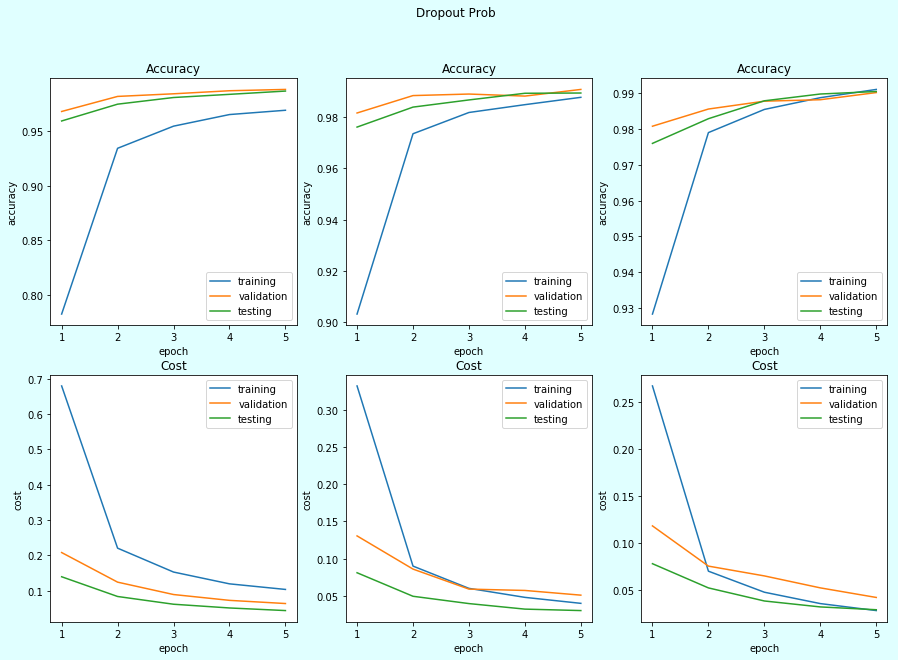

In [11]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('Dropout Prob')
ax = fig.subplots(2,3)

for i, param in enumerate(param_dropout):
    ax[0,i].set_title('Accuracy')
    ax[0,i].set_xlabel('epoch')
    ax[0,i].set_ylabel('accuracy')
    ax[0,i].plot(range(1,epoch+1),acc_train_set[i],label='training')
    ax[0,i].plot(range(1,epoch+1),acc_valid_set[i],label='validation')
    ax[0,i].plot(range(1,epoch+1),acc_test_set[i],label='testing')
    ax[0,i].legend()
    ax[1,i].set_title('Cost')
    ax[1,i].set_xlabel('epoch')
    ax[1,i].set_ylabel('cost')
    ax[1,i].plot(range(1,epoch+1),cost_train_set[i],label='training')
    ax[1,i].plot(range(1,epoch+1),cost_valid_set[i],label='validation')
    ax[1,i].plot(range(1,epoch+1),cost_test_set[i],label='testing')
    ax[1,i].legend()
    print('Parameter : %3.3f\n' %(param))
    print('Train_acc :  %7.3f | Valid_acc : %7.3f | Test_acc : %7.3f\n' % (acc_train_set[i][-1], acc_valid_set[i][-1], acc_test_set[i][-1]))
    


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

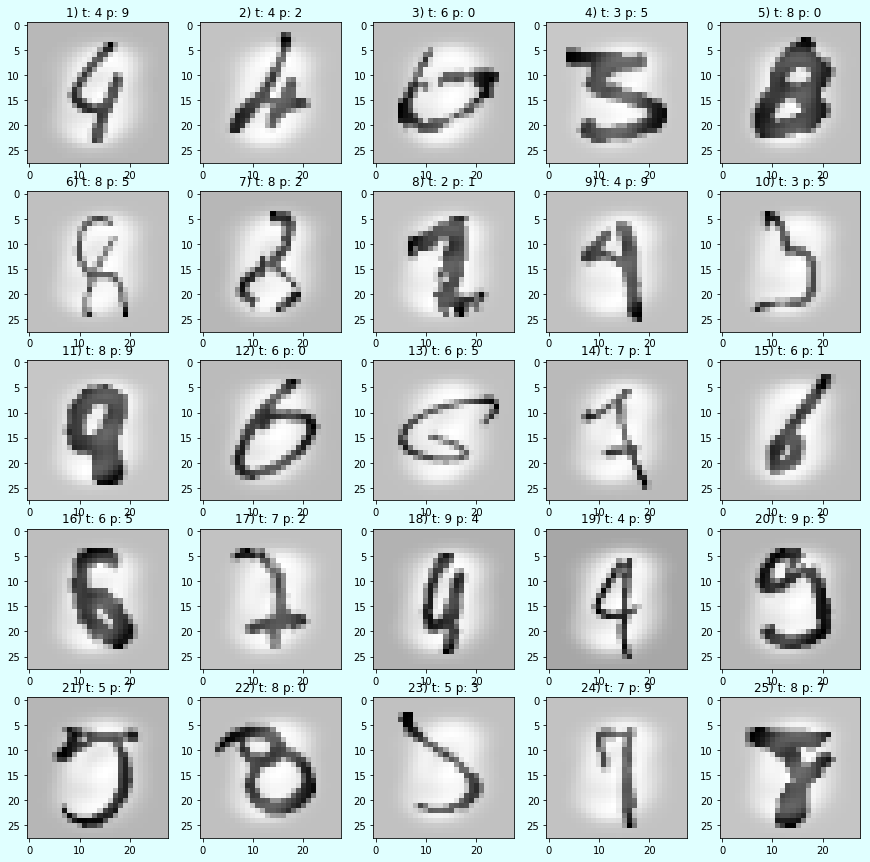

In [12]:
BEST = 1

## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn(LnReg = 0, LnBeta = 0)

## crearte a TF session and train the CNN model
with tf.Session(graph=g) as sess:
    [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
        = train(sess,
                training_set=(X_train_centered, y_train),
                validation_set=(X_valid_centered, y_valid),
                testing_set=(X_test_centered, y_test),
                initialize=True,
                epochs=epoch,
                shuffle=True,
                dropout=param_dropout[BEST],
                batch_size=64,
                mute=True,
                random_seed=123)
    y_test_pred = predict(sess, X_test_centered, return_proba=False)
miscl_img = X_test_centered[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]


fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('lightcyan')
ax = fig.subplots(5,5)
for i in range(5):
    for j in range(5):
        img = miscl_img[5*i+j].reshape(28, 28)
        ax[i,j].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i,j].set_title('%d) t: %d p: %d' % (5*i+j+1, correct_lab[5*i+j], miscl_lab[5*i+j]))

### Observation
- 대부분의 경우 98% 이상의 어마어마한 정확도를 보여주었다.
- keep_prob 가 0.1인 경우 training set에서 수행이 확 떨어짐을 확인할 수 있었다.(90% dropout)
- 거의 엇비슷한 정확도를 가지고 있었지만 dropout parameter를 0.500로 한경우 validation이나 test set 에서 수행이 조금 더 좋았다.
- 잘못 classify 된 sample들은 이전의 MLP와는 다르게 절반 이상은 사람이 봐도 구분을 못할 수준의 이상한 데이터였다.

## 4-2. L2 Regularization Parameter

In [13]:
## 조건에 대한 각각의 값을 미리 지정해둠.
acc_train_set = []
acc_valid_set = []
acc_test_set = []

cost_train_set = []
cost_valid_set = []
cost_test_set = []


for i, param in enumerate(param_L2):
    ## create a graph
    g = tf.Graph()
    with g.as_default():
        tf.set_random_seed(random_seed)
        ## build the graph
        build_cnn(LnReg = 2, LnBeta = param)

    ## crearte a TF session and train the CNN model
    with tf.Session(graph=g) as sess:
        [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
            = train(sess,
                    training_set=(X_train_centered, y_train),
                    validation_set=(X_valid_centered, y_valid),
                    testing_set=(X_test_centered, y_test),
                    initialize=True,
                    epochs=epoch,
                    shuffle=True,
                    dropout=0.5,
                    batch_size=64,
                    mute=False,
                    random_seed=123)
        acc_train_set.append(acc_train)
        acc_valid_set.append(acc_valid)
        acc_test_set.append(acc_test)
        cost_train_set.append(cost_train)
        cost_valid_set.append(cost_valid)
        cost_test_set.append(cost_test)
print('##################################################')
print('#########             DONE            ############')
print('##################################################')


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

Parameter : 0.000

Train_acc :    0.988 | Valid_acc :   0.990 | Test_acc :   0.990

Parameter : 0.100

Train_acc :    0.974 | Valid_acc :   0.982 | Test_acc :   0.980

Parameter : 0.001

Train_acc :    0.987 | Valid_acc :   0.988 | Test_acc :   0.990



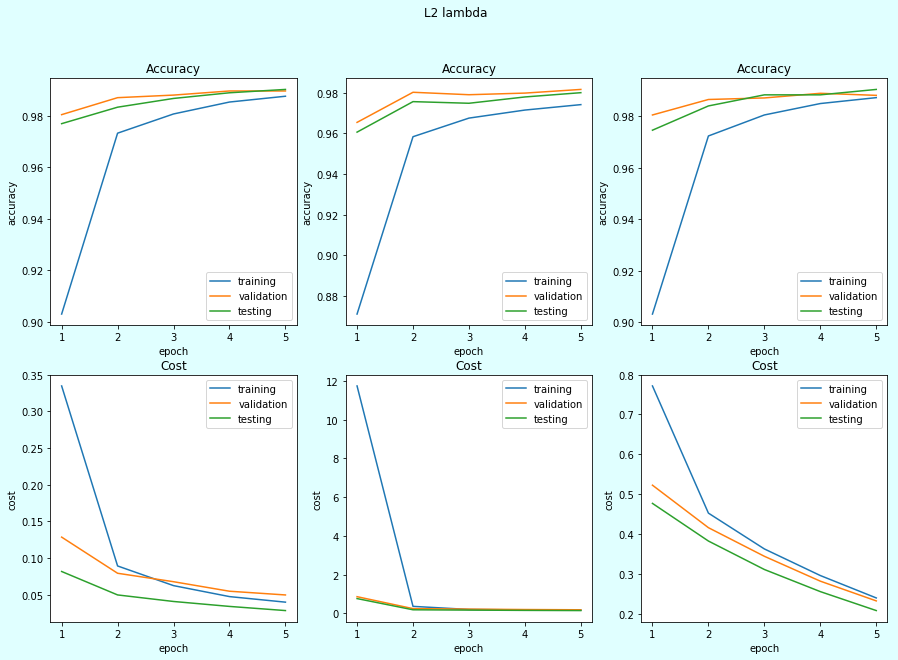

In [14]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('L2 lambda')
ax = fig.subplots(2,3)

for i, param in enumerate(param_L2):
    ax[0,i].set_title('Accuracy')
    ax[0,i].set_xlabel('epoch')
    ax[0,i].set_ylabel('accuracy')
    ax[0,i].plot(range(1,epoch+1),acc_train_set[i],label='training')
    ax[0,i].plot(range(1,epoch+1),acc_valid_set[i],label='validation')
    ax[0,i].plot(range(1,epoch+1),acc_test_set[i],label='testing')
    ax[0,i].legend()
    ax[1,i].set_title('Cost')
    ax[1,i].set_xlabel('epoch')
    ax[1,i].set_ylabel('cost')
    ax[1,i].plot(range(1,epoch+1),cost_train_set[i],label='training')
    ax[1,i].plot(range(1,epoch+1),cost_valid_set[i],label='validation')
    ax[1,i].plot(range(1,epoch+1),cost_test_set[i],label='testing')
    ax[1,i].legend()
    print('Parameter : %3.3f\n' %(param))
    print('Train_acc :  %7.3f | Valid_acc : %7.3f | Test_acc : %7.3f\n' % (acc_train_set[i][-1], acc_valid_set[i][-1], acc_test_set[i][-1]))
    


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

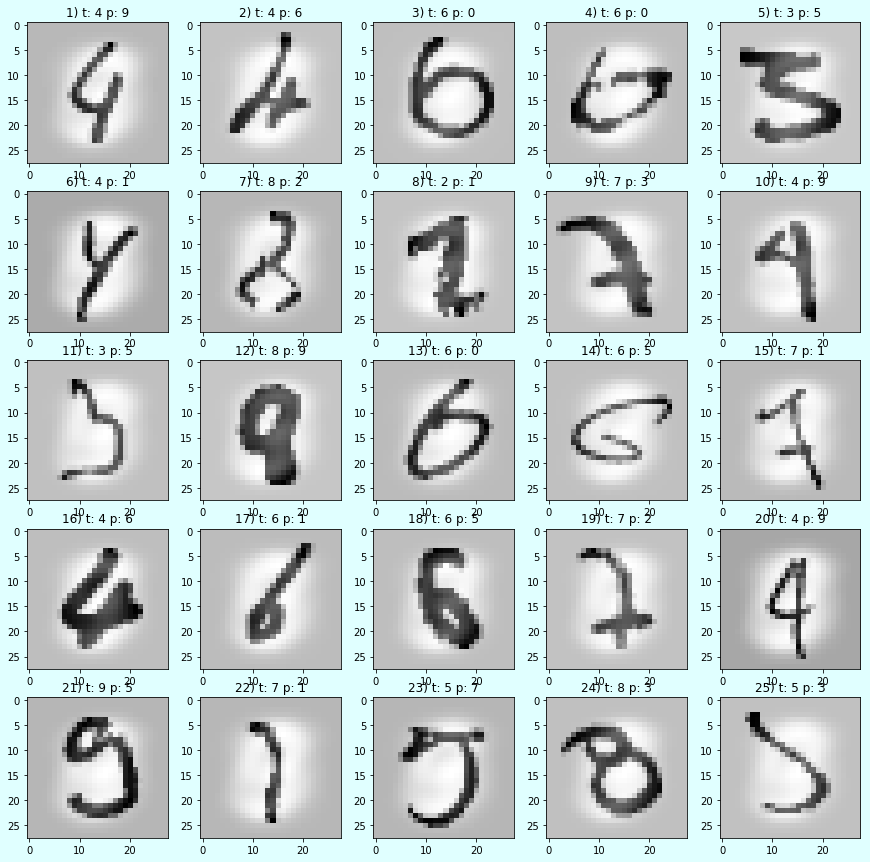

In [15]:
BEST = 2

## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn(LnReg = 2, LnBeta = param_L2[BEST])

## crearte a TF session and train the CNN model
with tf.Session(graph=g) as sess:
    [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
        = train(sess,
                training_set=(X_train_centered, y_train),
                validation_set=(X_valid_centered, y_valid),
                testing_set=(X_test_centered, y_test),
                initialize=True,
                epochs=epoch,
                shuffle=True,
                dropout=0.5,
                batch_size=64,
                mute=True,
                random_seed=123)
    y_test_pred = predict(sess, X_test_centered, return_proba=False)
miscl_img = X_test_centered[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]


fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('lightcyan')
ax = fig.subplots(5,5)
for i in range(5):
    for j in range(5):
        img = miscl_img[5*i+j].reshape(28, 28)
        ax[i,j].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i,j].set_title('%d) t: %d p: %d' % (5*i+j+1, correct_lab[5*i+j], miscl_lab[5*i+j]))

### Observation
- 이 역시 모든 조건에서 95%이상의 매우 높은 정확도를 보여주었다.
- 주목할만한 점은 람다 값이 0.001인 경우 validation과 testing set의 정확도가 99%까지 올라갔다는 것이다.
- 잘못 classifiy된 사진들도 역시 human error에 가까웠다.

## 4-3. L1 Regularization Parameter

In [16]:
## 조건에 대한 각각의 값을 미리 지정해둠.
acc_train_set = []
acc_valid_set = []
acc_test_set = []

cost_train_set = []
cost_valid_set = []
cost_test_set = []


for i, param in enumerate(param_L1):
    ## create a graph
    g = tf.Graph()
    with g.as_default():
        tf.set_random_seed(random_seed)
        ## build the graph
        build_cnn(LnReg = 1, LnBeta = param)

    ## crearte a TF session and train the CNN model
    with tf.Session(graph=g) as sess:
        [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
            = train(sess,
                    training_set=(X_train_centered, y_train),
                    validation_set=(X_valid_centered, y_valid),
                    testing_set=(X_test_centered, y_test),
                    initialize=True,
                    epochs=epoch,
                    shuffle=True,
                    dropout=0.5,
                    batch_size=64,
                    mute=False,
                    random_seed=123)
        acc_train_set.append(acc_train)
        acc_valid_set.append(acc_valid)
        acc_test_set.append(acc_test)
        cost_train_set.append(cost_train)
        cost_valid_set.append(cost_valid)
        cost_test_set.append(cost_test)
print('##################################################')
print('#########             DONE            ############')
print('##################################################')


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

Parameter : 0.000

Train_acc :    0.988 | Valid_acc :   0.991 | Test_acc :   0.992

Parameter : 0.100

Train_acc :    0.850 | Valid_acc :   0.921 | Test_acc :   0.905

Parameter : 0.001

Train_acc :    0.966 | Valid_acc :   0.982 | Test_acc :   0.977



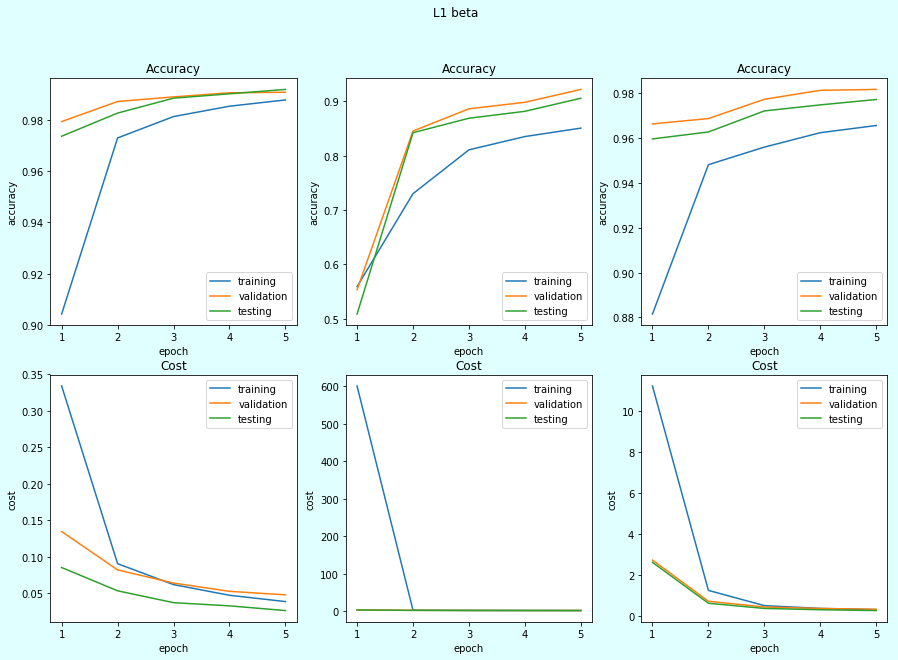

In [17]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('L1 beta')
ax = fig.subplots(2,3)

for i, param in enumerate(param_L1):
    ax[0,i].set_title('Accuracy')
    ax[0,i].set_xlabel('epoch')
    ax[0,i].set_ylabel('accuracy')
    ax[0,i].plot(range(1,epoch+1),acc_train_set[i],label='training')
    ax[0,i].plot(range(1,epoch+1),acc_valid_set[i],label='validation')
    ax[0,i].plot(range(1,epoch+1),acc_test_set[i],label='testing')
    ax[0,i].legend()
    ax[1,i].set_title('Cost')
    ax[1,i].set_xlabel('epoch')
    ax[1,i].set_ylabel('cost')
    ax[1,i].plot(range(1,epoch+1),cost_train_set[i],label='training')
    ax[1,i].plot(range(1,epoch+1),cost_valid_set[i],label='validation')
    ax[1,i].plot(range(1,epoch+1),cost_test_set[i],label='testing')
    ax[1,i].legend()
    print('Parameter : %3.3f\n' %(param))
    print('Train_acc :  %7.3f | Valid_acc : %7.3f | Test_acc : %7.3f\n' % (acc_train_set[i][-1], acc_valid_set[i][-1], acc_test_set[i][-1]))
    


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

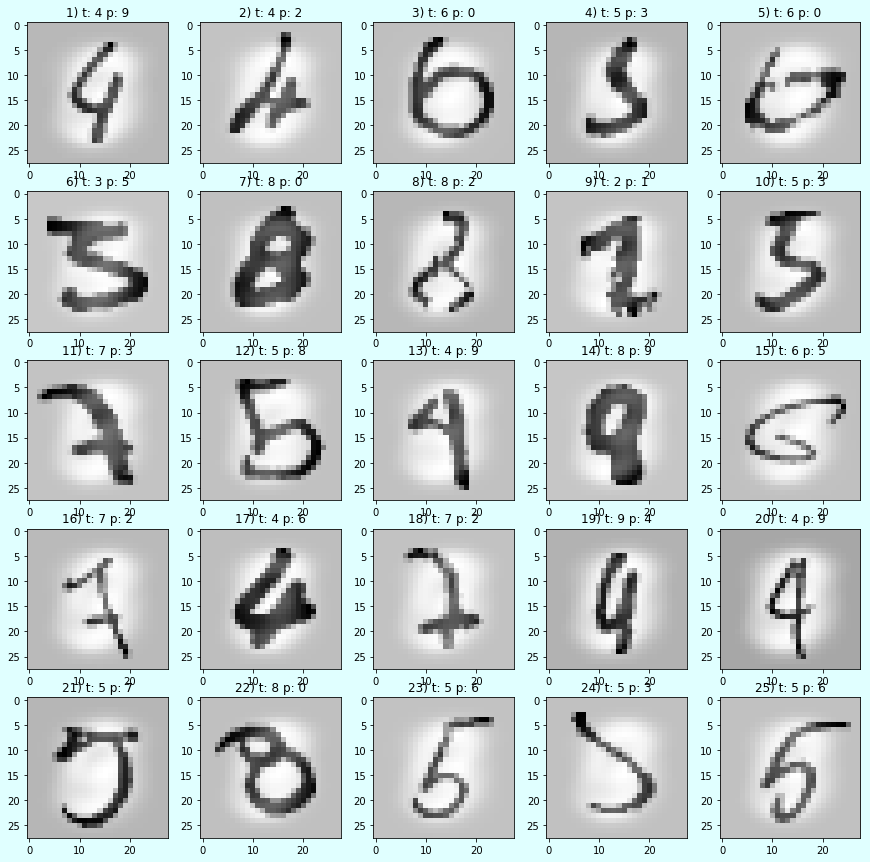

In [18]:
BEST = 0

## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn(LnReg = 1, LnBeta = param_L1[BEST])

## crearte a TF session and train the CNN model
with tf.Session(graph=g) as sess:
    [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
        = train(sess,
                training_set=(X_train_centered, y_train),
                validation_set=(X_valid_centered, y_valid),
                testing_set=(X_test_centered, y_test),
                initialize=True,
                epochs=epoch,
                shuffle=True,
                dropout=0.5,
                batch_size=64,
                mute=True,
                random_seed=123)
    y_test_pred = predict(sess, X_test_centered, return_proba=False)
miscl_img = X_test_centered[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]


fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('lightcyan')
ax = fig.subplots(5,5)
for i in range(5):
    for j in range(5):
        img = miscl_img[5*i+j].reshape(28, 28)
        ax[i,j].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i,j].set_title('%d) t: %d p: %d' % (5*i+j+1, correct_lab[5*i+j], miscl_lab[5*i+j]))

### Observation
- L1 beta 값의 경우 일관적이지는 않은 결과를 보여주었다.
- beta 값이 0일때 가장 수행이 좋았으며, 0.1인 경우는 초반에 매우 높은 cost 값이 나타났다. (아마 weight의 수가 많은데 초기화가 안된 상태라 높게 잡힌것이 아닐까)
- 잘못 분류된 이미지들도 일부만 human error로 보였다.

## 4-4. mini-batch size

In [21]:
## 조건에 대한 각각의 값을 미리 지정해둠.
acc_train_set = []
acc_valid_set = []
acc_test_set = []

cost_train_set = []
cost_valid_set = []
cost_test_set = []


for i, param in enumerate(param_batch):
    ## create a graph
    g = tf.Graph()
    with g.as_default():
        tf.set_random_seed(random_seed)
        ## build the graph
        build_cnn(LnReg = 0, LnBeta = 0)

    ## crearte a TF session and train the CNN model
    with tf.Session(graph=g) as sess:
        [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
            = train(sess,
                    training_set=(X_train_centered, y_train),
                    validation_set=(X_valid_centered, y_valid),
                    testing_set=(X_test_centered, y_test),
                    initialize=True,
                    epochs=epoch,
                    shuffle=True,
                    dropout=0.5,
                    batch_size=param,
                    mute=False,
                    random_seed=123)
        acc_train_set.append(acc_train)
        acc_valid_set.append(acc_valid)
        acc_test_set.append(acc_test)
        cost_train_set.append(cost_train)
        cost_valid_set.append(cost_valid)
        cost_test_set.append(cost_test)
print('##################################################')
print('#########             DONE            ############')
print('##################################################')


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

Parameter : 1.000

Train_acc :    0.993 | Valid_acc :   0.990 | Test_acc :   0.990

Parameter : 4.000

Train_acc :    0.994 | Valid_acc :   0.990 | Test_acc :   0.990

Parameter : 16.000

Train_acc :    0.992 | Valid_acc :   0.991 | Test_acc :   0.990

Parameter : 64.000

Train_acc :    0.988 | Valid_acc :   0.991 | Test_acc :   0.990

Parameter : 128.000

Train_acc :    0.984 | Valid_acc :   0.989 | Test_acc :   0.988

Parameter : 1024.000

Train_acc :    0.958 | Valid_acc :   0.979 | Test_acc :   0.971



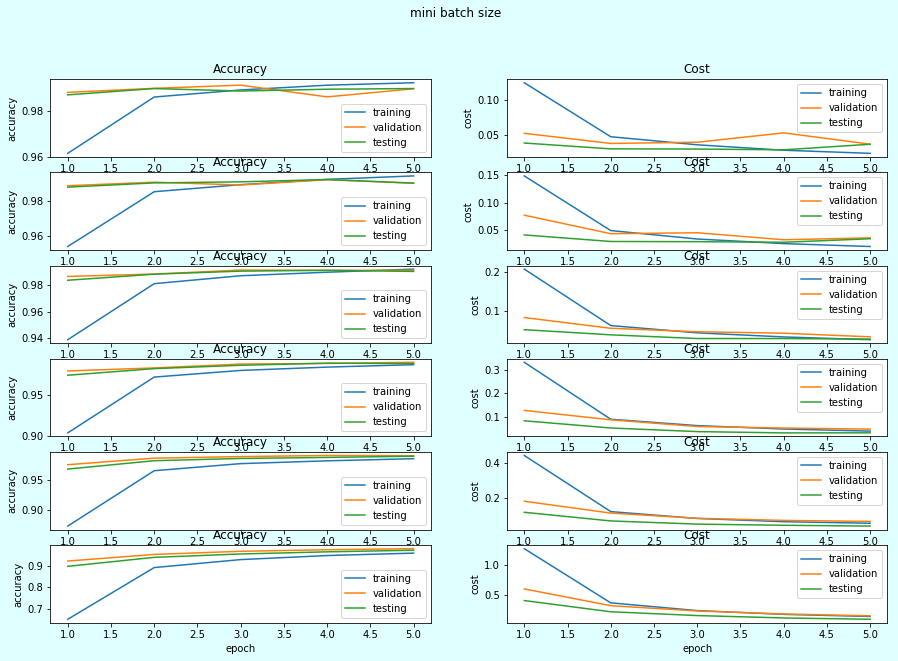

In [22]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('mini batch size')
ax = fig.subplots(6,2)

for i, param in enumerate(param_batch):
    ax[i,0].set_title('Accuracy')
    ax[i,0].set_xlabel('epoch')
    ax[i,0].set_ylabel('accuracy')
    ax[i,0].plot(range(1,epoch+1),acc_train_set[i],label='training')
    ax[i,0].plot(range(1,epoch+1),acc_valid_set[i],label='validation')
    ax[i,0].plot(range(1,epoch+1),acc_test_set[i],label='testing')
    ax[i,0].legend()
    ax[i,1].set_title('Cost')
    ax[i,1].set_xlabel('epoch')
    ax[i,1].set_ylabel('cost')
    ax[i,1].plot(range(1,epoch+1),cost_train_set[i],label='training')
    ax[i,1].plot(range(1,epoch+1),cost_valid_set[i],label='validation')
    ax[i,1].plot(range(1,epoch+1),cost_test_set[i],label='testing')
    ax[i,1].legend()
    print('Parameter : %3.3f\n' %(param))
    print('Train_acc :  %7.3f | Valid_acc : %7.3f | Test_acc : %7.3f\n' % (acc_train_set[i][-1], acc_valid_set[i][-1], acc_test_set[i][-1]))
    


Building 1st layer: 
<tf.Variable 'conv_1/_weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>
<tf.Variable 'conv_1/_biases:0' shape=(32,) dtype=float32_ref>
Tensor("conv_1/Conv2D:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/net_pre-activation:0", shape=(?, 24, 24, 32), dtype=float32)
Tensor("conv_1/activation:0", shape=(?, 24, 24, 32), dtype=float32)

Building 2nd layer: 
<tf.Variable 'conv_2/_weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>
<tf.Variable 'conv_2/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv_2/Conv2D:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/net_pre-activation:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("conv_2/activation:0", shape=(?, 8, 8, 64), dtype=float32)

Building 3rd layer:
<tf.Variable 'fc_3/_weights:0' shape=(1024, 1024) dtype=float32_ref>
<tf.Variable 'fc_3/_biases:0' shape=(1024,) dtype=float32_ref>
Tensor("fc_3/MatMul:0", shape=(?, 1024), dtype=float32)
Tensor("fc_3/net_pre-activation:0", shape=(?, 1024), dtype=float32

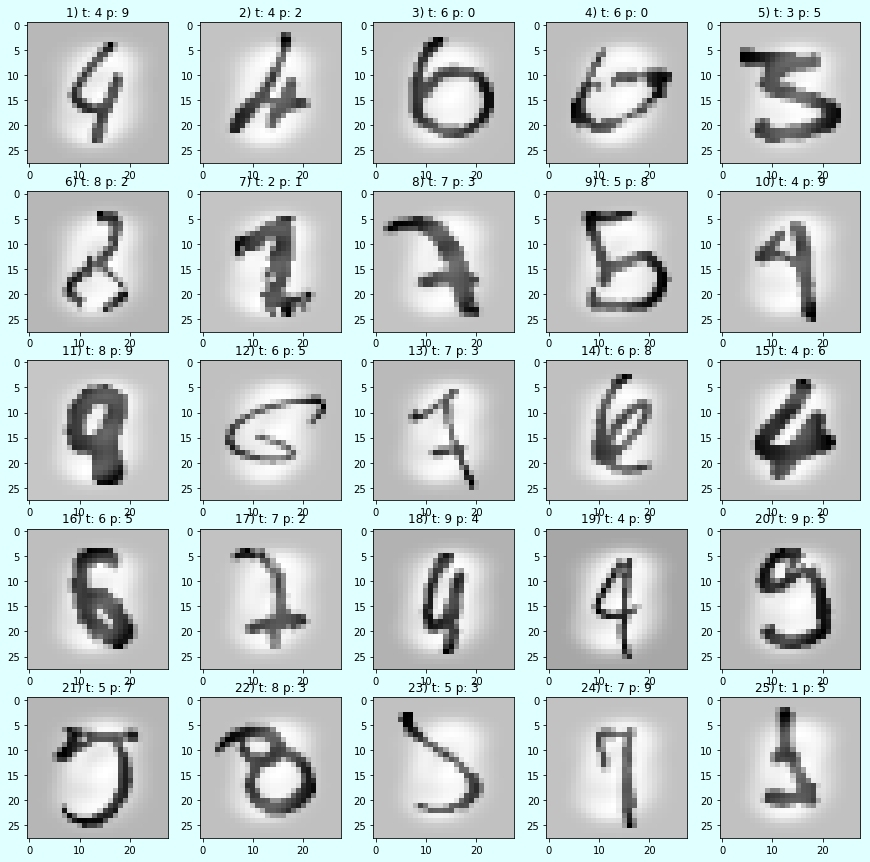

In [23]:
BEST = 3

## create a graph
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    ## build the graph
    build_cnn(LnReg = 0, LnBeta = 0)

## crearte a TF session and train the CNN model
with tf.Session(graph=g) as sess:
    [acc_train, acc_valid, acc_test, cost_train, cost_valid, cost_test] \
        = train(sess,
                training_set=(X_train_centered, y_train),
                validation_set=(X_valid_centered, y_valid),
                testing_set=(X_test_centered, y_test),
                initialize=True,
                epochs=epoch,
                shuffle=True,
                dropout=0.5,
                batch_size=param_batch[BEST],
                mute=True,
                random_seed=123)
    y_test_pred = predict(sess, X_test_centered, return_proba=False)
miscl_img = X_test_centered[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]


fig = plt.figure(figsize=(15,15))
fig.patch.set_facecolor('lightcyan')
ax = fig.subplots(5,5)
for i in range(5):
    for j in range(5):
        img = miscl_img[5*i+j].reshape(28, 28)
        ax[i,j].imshow(img, cmap='Greys', interpolation='nearest')
        ax[i,j].set_title('%d) t: %d p: %d' % (5*i+j+1, correct_lab[5*i+j], miscl_lab[5*i+j]))

### Observation
- 안타깝게도 55000개의 샘플을 한번에 돌리는 옵션은 GPU 메모리 부족현상으로 현재 개발환경에서는 돌려볼 수 없었다. (GeForce 950)
- 이전에도 확인할 수 있었지만 batch size가 작아지면 한 epoch을 돌리는데 너무 오래걸린다.
- 가장 최적의 batch size의 경우 16으로 확인되었다.
